In [1]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import scipy.stats, os, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
import os, sys
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

# Configuration

In [3]:
def read_image_json(file_path, metric):
    with open(file_path, 'r') as f:
        results = json.load(f)[0]
    if metric == 'overall':
        score = results['strict_score'] * results['number'] / 1000
    elif metric == 'textual':
        score = results['first_score'] * results['number'] / 1000
    elif metric == 'visual':
        score = results['second_score'] * results['number'] / 1000
    else:
        raise ValueError('Invalid metric')
    return score
        


def get_acc(model_mode, metric, dataid = 1, num_shot = 1, model = 'gill', misleading = 0):
    if model_mode == 'image':
        metric_model = 'llava'
    elif model_mode == 'text':
        metric_model = 'gpt'
    else:
        raise ValueError('Invalid task')
    
    results_dir = os.path.join(root_dir, 'results')
    misleading_flag = '_m' if misleading else ''

    results_dir = os.path.join(results_dir, f'{metric_model}_evaluation{misleading_flag}')
    
    # find all the files in the directory
    files = os.listdir(results_dir)
    for file in files:
        if model_mode == 'image':
            if f'[1][{dataid}]' in file and f'{model}_{num_shot}shot' in file:
                file_path = os.path.join(results_dir, file)
                return read_image_json(file_path, metric)
        elif model_mode == 'text':
            if f'[{dataid}]' in file and f'{model}_{num_shot}shot' in file:
                file_path = os.path.join(results_dir, file)
                with open(file_path, 'r') as f:
                    results = json.load(f)
                    return results[0][metric]
    return 0

In [4]:
tasks = {
    'simple': {
        'Color-I': 1, 
        'Count-I': 3,
        'Style-I': 5,
        'Action-I': 7,
        'Background-I': 9,
    },
    'challenge': {
        'Color-II': 2, 
        'Count-II': 4,
        'Style-II': 6,
        'Action-II': 8,
        'Background-II': 10,
    },
    'all':{
        'Color-I': 1, 
        'Color-II': 2, 
        'Count-I': 3, 
        'Count-II': 4,
        'Style-I': 5, 
        'Style-II': 6,
        'Action-I': 7, 
        'Action-II': 8,
        'Background-I': 9, 
        'Background-II': 10,
    }
}
model_dict = {
    'image': {
        'Emu': 'Emu',
        'GILL': 'gill',
        'SEED-LLaMA': 'SEED',
    },
    'text': {
        'Emu': 'Emu',
        'GILL': 'gill',
        'SEED-LLaMA': 'SEED',
        'GPT-4V': 'openai',
        'Qwen-VL': 'qwen',
        'LLaVA': 'llava',
    }
}

colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

# Overall Performance Report

In [5]:
def get_shot_bars(
    num_shot,
    difficulty,
    model_mode,
    metric,
    misleading,
):
    return [
        {
            'model': model_label, 
            'task': task, 
            'acc': get_acc(
                model_mode, 
                metric, 
                dataid = dataid, 
                num_shot = num_shot, 
                model = model_dict[model_mode][model_label], 
                misleading = misleading,
            ),
        } 
        for task, dataid in tasks[difficulty].items() for model_label in model_dict[model_mode] 
    ]

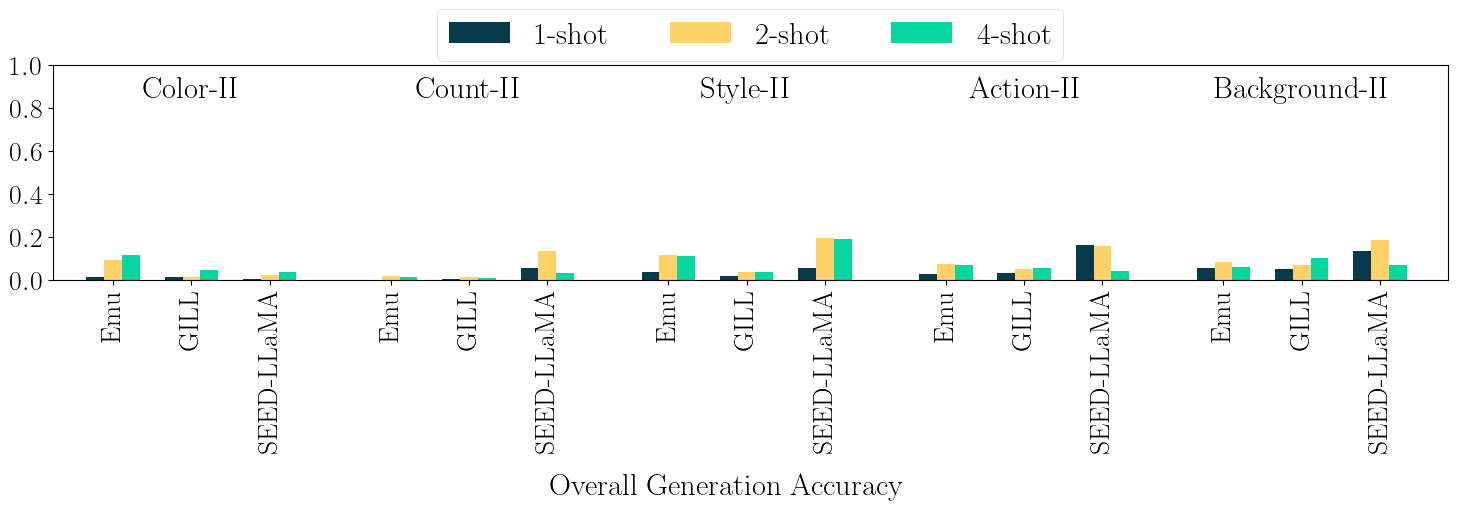

In [6]:
bar_width = 2.5
difficulty = 'challenge'
model_mode = 'image'
width, height = 15, 5
misleading = 1
metric = 'overall'
wspace = 6
barspace = 11

r1_data = get_shot_bars(
    1,
    difficulty,
    model_mode,
    metric,
    misleading,
)
r1_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])), **r1_data[i]} for i in range(len(r1_data))]

r2_data = get_shot_bars(
    2,
    difficulty,
    model_mode,
    metric,
    misleading,
)
r2_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + bar_width, **r2_data[i]} for i in range(len(r2_data))]

r3_data = get_shot_bars(
    4,
    difficulty,
    model_mode,
    metric,
    misleading,
)
r3_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 2 * bar_width, **r3_data[i]} for i in range(len(r3_data))]


fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.05, bottom=.45, right=0.98, top=.88, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

xticks, xticklabels = [], []
for i, (v1, v2, v3) in enumerate(zip(r1_data, r2_data, r3_data)):
    ax.bar(v1['position'], v1['acc'], width = bar_width, color = colors[0], label = '1-shot')
    ax.bar(v2['position'], v2['acc'], width = bar_width, color = colors[1], label = '2-shot')
    ax.bar(v3['position'], v3['acc'], width = bar_width, color = colors[2], label = '4-shot')
    xticks.append(v2['position'])
    xticklabels.append(v2['model'])
    
    if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1)//2:
        ax.text(v2['position'], 0.85, v2['task'], fontsize=22, fontweight='bold', ha='center')
    
    # add legend
    if i == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33), ncol=3, fontsize=22)
        
ax.set_xticks(xticks)
ax.set_xlim(-wspace, wspace + barspace*(len(r1_data)-1) + wspace*(len(r1_data)//len(model_dict[model_mode])))
# break the line of the xticklabels
ax.set_xticklabels(xticklabels, rotation = 90)
ax.set_yticks(np.arange(0, 1.2, 0.2))
# annotate every three clusters of bars with the dataset name
fig.supxlabel('Overall Generation Accuracy', fontsize=22)
fig.savefig(f'{root_dir}/figures/{difficulty}_m_{misleading}_{model_mode}.pdf')
plt.show()

In [ ]:
# Task sort

record = defaultdict(dict)
min_acc = {}
    
for v in r1_data + r2_data + r3_data:
    record[v['model']][v['task']] = max(record[v['model']].get(v['task'], 0), v['acc'])
    
for task in tasks['all']:
    min_acc[task] = min([record[model][task] for model in record])
    
sorted(tasks['all'], key = lambda x: min_acc[x], reverse = True)

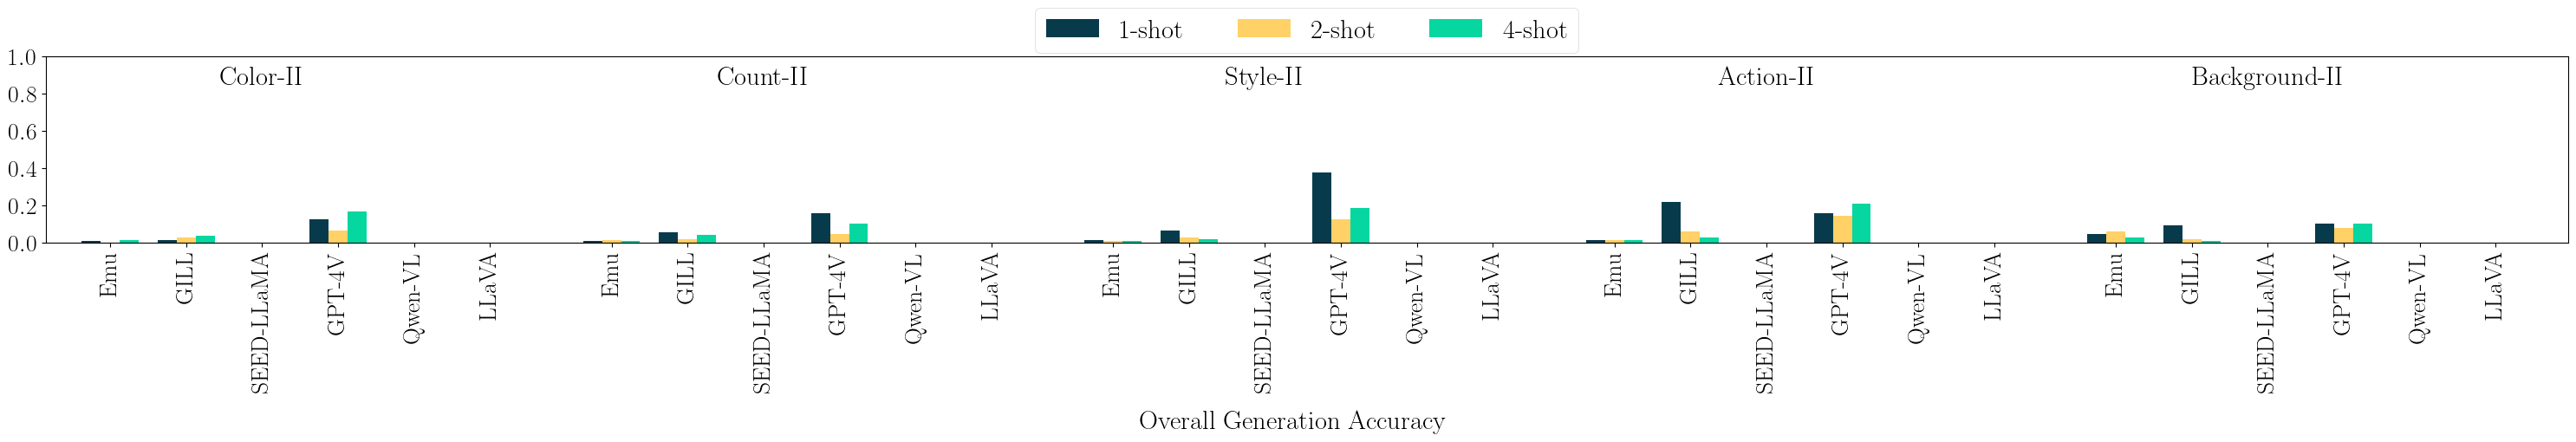

In [8]:
bar_width = 2.5
difficulty = 'challenge'
model_mode = 'text'
width, height = 30, 5
misleading = 0
metric = 'overall'
wspace = 6
barspace = 10

r1_data = get_shot_bars(
    1,
    difficulty,
    model_mode,
    metric,
    misleading,
)
r1_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])), **r1_data[i]} for i in range(len(r1_data))]

r2_data = get_shot_bars(
    2,
    difficulty,
    model_mode,
    metric,
    misleading,
)
r2_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + bar_width, **r2_data[i]} for i in range(len(r2_data))]

r3_data = get_shot_bars(
    4,
    difficulty,
    model_mode,
    metric,
    misleading,
)
r3_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 2 * bar_width, **r3_data[i]} for i in range(len(r3_data))]


fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.02, bottom=.45, right=0.99, top=.88, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

xticks, xticklabels = [], []
for i, (v1, v2, v3) in enumerate(zip(r1_data, r2_data, r3_data)):
    ax.bar(v1['position'], v1['acc'], width = bar_width, color = colors[0], label = '1-shot')
    ax.bar(v2['position'], v2['acc'], width = bar_width, color = colors[1], label = '2-shot')
    ax.bar(v3['position'], v3['acc'], width = bar_width, color = colors[2], label = '4-shot')
    xticks.append(v2['position'])
    xticklabels.append(v2['model'])
    
    if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1)//2:
        ax.text(v2['position'], 0.85, v2['task'], fontsize=22, fontweight='bold', ha='center')
    
    # add legend
    if i == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33), ncol=3, fontsize=22)
        
ax.set_xticks(xticks)
# break the line of the xticklabels
ax.set_xticklabels(xticklabels, rotation = 90)
ax.set_xlim(-wspace, wspace + barspace*(len(r1_data)-1) + wspace*(len(r1_data)//len(model_dict[model_mode])))
ax.set_yticks(np.arange(0, 1.2, 0.2))
# annotate every three clusters of bars with the dataset name
fig.supxlabel('Overall Generation Accuracy', fontsize=22)
fig.savefig(f'{root_dir}/figures/{difficulty}_m_{misleading}_{model_mode}.pdf')
plt.show()

# 